In [3]:
import pandas as pd

#Load Data

films = pd.read_csv('film_data/movies.csv')

metadata = pd.read_csv('film_data/movies_metadata.csv')

ratings = pd.read_csv("film_data/ratings.csv")

films['title'] = films['title'].str[:-7] #early cleaning needed to be able to join on movie titles

#Merge Tables

new_merge =  films.merge(metadata, left_on='title', right_on='original_title', how='inner')

final_merge = new_merge.merge(ratings, on='movieId', how='inner')

/var/folders/j8/qk3qs96x2mg8j_pp6thc7r280000gn/T/ipykernel_28849/2095170343.py:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('film_data/movies_metadata.csv')


### Begin NLP Model for Embeddings

In [4]:
#first subset for storing unique movie overviews. easier to just keep unique movies, only 6k more rows.
embed_df = final_merge[['movieId','title_x', 'overview']]
embed_df = embed_df.dropna()
sub_embed = embed_df.drop_duplicates(subset=['movieId']) 
titles = list(sub_embed['overview'])

In [5]:
import tensorflow as tf
import tensorflow_hub as hub

#load model
model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(model_url)
print('Model Loaded')

2023-08-28 12:07:25.701523: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model Loaded


In [25]:
#function for generating embeddings from text
def embed(texts):
    return model(texts)

In [7]:
embeddings = embed(titles)
print('The embedding shape is:', embeddings.shape)

2023-08-28 12:07:42.626335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]


The embedding shape is: (14978, 512)


In [9]:
#sub_embed is same length as embeddings so we create a dictionary here
import numpy as np
embed_dict = {title: np.array(embedding) for title, embedding in zip(sub_embed.movieId, embeddings)}

In [10]:
#loop to check structure of dictionary
for title, embedding in embed_dict.items():
    print(title, embedding)
    break

1 [ 0.06237841 -0.0002126  -0.03214182  0.04211934 -0.03190544 -0.04727347
 -0.03579685 -0.06527698 -0.01243673 -0.01291866 -0.03203537  0.05493605
 -0.04103911  0.01471263 -0.03063926 -0.06317659 -0.0466479   0.04065034
 -0.05278565  0.05723298 -0.01752138 -0.06640148  0.06812549 -0.0296473
  0.00514266  0.06729303 -0.03282262 -0.02283402  0.048966    0.06429421
 -0.02937898 -0.06723911 -0.05709471 -0.04732318 -0.04401303 -0.03806524
  0.02364937  0.03226626  0.01851919 -0.05438094 -0.0125994  -0.03234721
 -0.00504968 -0.05542825 -0.05961058  0.06569341  0.04169374  0.03052215
 -0.03209818 -0.05397085  0.06841838 -0.00631817  0.00088383 -0.0468028
  0.05728187  0.0501298  -0.03235422  0.04091229  0.06377689  0.02186142
  0.06880636 -0.02428689 -0.06880655  0.01236477  0.0594555  -0.0257941
  0.03447117 -0.02245607  0.04398768 -0.02244513  0.05725091  0.04033455
  0.01818005 -0.0038235  -0.05242835 -0.05865093 -0.01320275  0.02778832
  0.0671078   0.01371305  0.05083869  0.03653849  0.

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

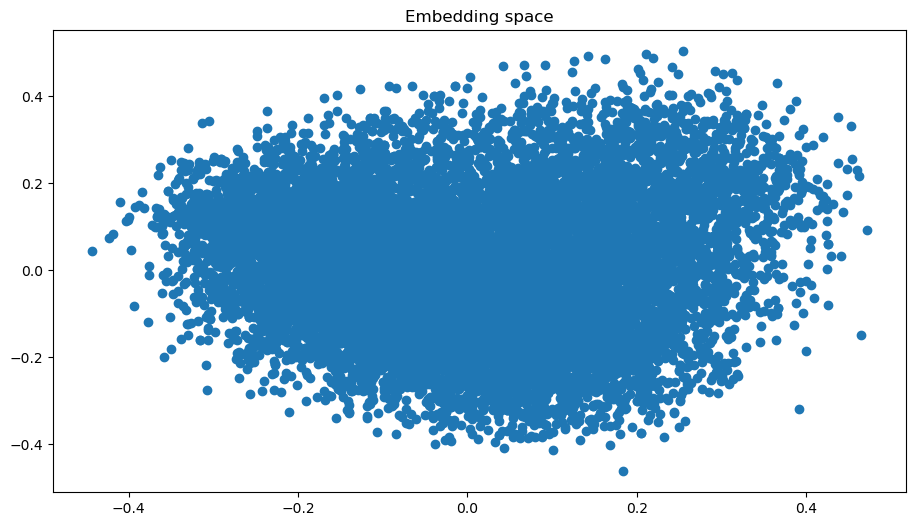

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 6))
plt.title('Embedding space')
plt.scatter(emb_2d[:, 0], emb_2d[:, 1])
plt.show()

In [19]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=10)
nn.fit(embeddings)

NearestNeighbors(n_neighbors=10)

In [46]:
# #testing this method on a simple model. generating predictions, will attempt to use for recommendations.

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

testdf = final_merge.sample(n = 100000, random_state = 42)

testdf = testdf.dropna()

X = embed(list(testdf['overview']))
Y = testdf['rating']

X = np.array(X)

modelA = KNeighborsRegressor(n_neighbors= 5, weights= 'distance') # penlizes far movies

cross_val_score(modelA, X, Y)#, scoring = "neg_root_mean_squared_error", cv = 5)

array([-0.01780328, -0.06492614, -0.09720365, -0.05080693, -0.0531002 ])

In [47]:
#now using model to generate recommendations
def recommend_movies(text):
    emb = embed([text])
    neighbors = nn.kneighbors(emb, return_distance=False)[0] #intended to embed the nearest neighbors of multiple inputs. 
    return sub_embed['title_x'].iloc[neighbors].tolist()

In [49]:
#recommend movies based on general text embeddings
print('Recommended Movies:')
recommend_movies("Harry Potter")

Recommended Movies:


['Harry Potter and the Goblet of Fire',
 'Harry Potter and the Deathly Hallows: Part 2',
 'Harry Potter and the Prisoner of Azkaban',
 'Harry Potter and the Deathly Hallows: Part 1',
 'Harry Potter and the Half-Blood Prince',
 'Harry Potter and the Chamber of Secrets',
 'Harry Potter and the Order of the Phoenix',
 'Luv',
 "Let's Get Harry",
 "It's a Small World"]

### Now Building NLP Recommender

In [50]:
usersub = final_merge.sample(frac = 0.1, random_state = 42)

usersub = usersub.dropna()

usersub.genres_x = usersub['genres_x'].str.replace('|', " ")

min_movie_ratings = 2 #a movie has was rated at least 
min_user_ratings =  5 #a user rated movies at least


filtered_ratings = usersub.groupby("movieId").filter(lambda x: x['movieId'].count() >= min_movie_ratings)
filtered_ratings = usersub.groupby("userId").filter(lambda x: x['userId'].count() >= min_user_ratings)

usersub = filtered_ratings #may interfere with above cells. clean up names for consistency later

In [51]:
usersub.shape

(58216, 30)

In [52]:
def get_movies_watched(user_data):
    #pos_user_data = user_data[user_data['rating']>=2]
    user_embeds = np.array(user_data['movieId'].map(embed_dict).tolist())
    user_avg = np.average(user_embeds, axis = 0, weights = user_data['rating'].values**2)
    return user_avg

In [53]:
user_avg_embeddings_full = usersub.groupby('userId').apply(lambda x: get_movies_watched(x)) # for full average

In [54]:
#function to compute similarity scores and generate predictions
from sklearn.metrics.pairwise import cosine_similarity
def generate_predictions_sem4(movieId, userId):
    user_embedding = user_avg_embeddings_full[userId]
    movie_embedding = embed_dict[movieId]
    #similarity_score = 1 / (1 + np.linalg.norm(movie_embedding - user_embedding))
    similarity_score = cosine_similarity([movie_embedding], [user_embedding])[0][0]
    predicted_score = similarity_score * 5  # 5 is max rating
    return predicted_score

#mention euclidean tests, positive movies, genre targeting in paper

In [55]:
# Testing the model
#embsub = final_merge.sample(n = 300000, random_state = 42)

test_data = usersub[['movieId', 'userId']].values
test_real = usersub['rating'].values

In [56]:
#comparing to old predictions
predictions_sem4 = []
for data in test_data:
    userId, movieId = data
    pred_score = generate_predictions_sem4(userId, movieId)
    predictions_sem4.append(pred_score)

In [57]:
#latest one that has genre targeted averages
rmseSemantic4 = np.sqrt(np.mean((test_real - predictions_sem4)**2))
print(f'RMSE = {rmseSemantic4}')

RMSE = 0.9314005428481431


In [60]:
mae_sem4 = np.mean(np.abs(test_real - predictions_sem4))
mae_sem4
#was previously 1.24

0.770042472169165